## 齐夫（Zipf）定律

### 导入模块并配置环境

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyhanlp import *
import numpy as np
import collections
from sys import getsizeof
import time
import re
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
%matplotlib inline
font = {'family' : 'SimHei',
         'weight' : 'bold',
         'size'   : '16'}
plt.rc('font', **font)               # 设置字体的更多属性,
plt.rc('axes', unicode_minus=False)  # 解决坐标轴负数的负号显示问题

sighan05 = "./第二届国际中文分词评测/icwb2-data/"
SogouW = "./SogouW/Freq/SogouLabDic.dic"

### 统计词频

In [12]:
msr = os.path.join(sighan05, 'training', 'msr_training.utf8')

f = collections.Counter()
with open(msr,encoding="utf-8") as src:
    for line in src:
        line = line.strip()
        for word in line.split('  '):
            # word = word.strip()
            # if len(word) < 2: continue
            f[word] += 1

### 齐夫（Zipf）定律

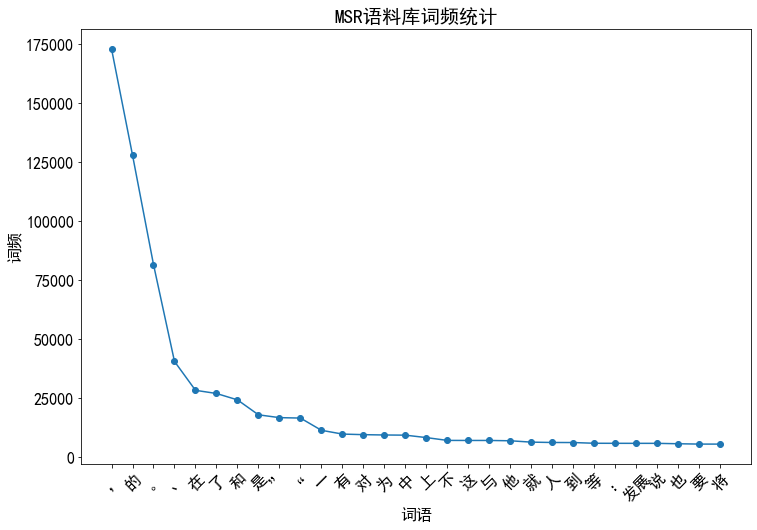

In [13]:
word,freq = zip(*f.most_common(30))
plt.figure(figsize=(12,8))
plt.plot(word,freq,"-o")
plt.xticks(rotation=45)
plt.title("MSR语料库词频统计")
plt.xlabel('词语')
plt.ylabel('词频')
plt.show()

## 词典分词

### 加载词典

In [10]:
def load_dictionary(dict_file):
    """
    加载词库
    :return: 一个set形式的词库
    """
    fr = open(dict_file,encoding="utf-8")
    word_list = [item.strip().split("\t")[0] for item in fr]
    return set(word_list)

word_dict = load_dictionary(SogouW)

In [17]:
len(word_dict)

157202

In [18]:
# 占用内存大小
getsizeof(word_dict)

4194528

### 构建测试数据

In [5]:
# 测试例子
test_cases = ['项目的研究',
              '商品和服务',
              '研究生命起源',
              '当下雨天地面积水',
              '结婚的和尚未结婚的',
              '欢迎新老师生前来就餐']

### 完全切分

In [21]:
def fully_segment(text, dic):
    word_list = []
    for i in range(len(text)):                  # i 从 0 到text的最后一个字的下标遍历
        for j in range(i + 1, len(text) + 1):   # j 遍历[i + 1, len(text)]区间
            word = text[i:j]                    # 取出连续区间[i, j]对应的字符串
            if word in dic:                     # 如果在词典中，则认为是一个词
                word_list.append(word)
    return word_list

for case in test_cases:
    print(fully_segment(case, word_dict))

['项目', '目的', '研究']
['商品', '和服', '和服务', '服务']
['研究', '研究生', '生命', '起源']
['当下', '下雨', '下雨天', '雨天', '天地', '地面', '面积', '积水']
['结婚', '和尚', '尚未', '结婚']
['欢迎', '欢迎新', '迎新', '新老', '老师', '师生', '生前', '前来', '就餐']


### 正向最长匹配

In [10]:
def forward_segment(text, dic):
    word_list = []
    i = 0
    while i < len(text):
        longest_word = text[i]                      # 当前扫描位置的单字
        for j in range(i + 1, len(text) + 1):       # 所有可能的结尾
            word = text[i:j]                        # 从当前位置到结尾的连续字符串
            if word in dic:                         # 在词典中
                if len(word) > len(longest_word):   # 并且更长
                    longest_word = word             # 则更优先输出
        word_list.append(longest_word)              # 输出最长词
        i += len(longest_word)                      # 正向扫描
    return word_list

for case in test_cases:
    print(forward_segment(case, word_dict))

['项目', '的', '研究']
['商品', '和服务']
['研究生', '命', '起源']
['当下', '雨天', '地面', '积水']
['结婚', '的', '和尚', '未', '结婚', '的']
['欢迎新', '老师', '生前', '来', '就餐']


### 逆向最长匹配

In [23]:
def backward_segment(text, dic):
    word_list = []
    i = len(text) - 1
    while i >= 0:                                   # 扫描位置作为终点
        longest_word = text[i]                      # 扫描位置的单字
        for j in range(0, i):                       # 遍历[0, i]区间作为待查询词语的起点
            word = text[j: i + 1]                   # 取出[j, i]区间作为待查询单词
            if word in dic:
                if len(word) > len(longest_word):   # 越长优先级越高
                    longest_word = word
                    break
        word_list.insert(0, longest_word)           # 逆向扫描，所以越先查出的单词在位置上越靠后
        i -= len(longest_word)
    return word_list

for case in test_cases:
    print(backward_segment(case, word_dict))

['项', '目的', '研究']
['商品', '和服务']
['研究', '生命', '起源']
['当', '下雨天', '地面', '积水']
['结婚', '的', '和', '尚未', '结婚', '的']
['欢迎', '新老', '师生', '前来', '就餐']


### 双向最长匹配

In [24]:
def count_single_char(word_list: list):  # 统计单字成词的个数
    return sum(1 for word in word_list if len(word) == 1)


def bidirectional_segment(text, dic):
    f = forward_segment(text, dic)
    b = backward_segment(text, dic)
    if len(f) < len(b):                                  # 词数更少优先级更高
        return f
    elif len(f) > len(b):
        return b
    else:
        if count_single_char(f) < count_single_char(b):  # 单字更少优先级更高
            return f
        else:
            return b                                     # 都相等时逆向匹配优先级更高
        
for case in test_cases:
    print(bidirectional_segment(case, word_dict))

['项', '目的', '研究']
['商品', '和服务']
['研究', '生命', '起源']
['当下', '雨天', '地面', '积水']
['结婚', '的', '和', '尚未', '结婚', '的']
['欢迎', '新老', '师生', '前来', '就餐']


### 速度测评

In [41]:
def evaluate_speed(segment, text, dic, pressure = 10000):
    start_time = time.time()
    for i in range(pressure):
        segment(text, dic)
    elapsed_time = time.time() - start_time
    seg_speed = len(text) * pressure / 10000 / elapsed_time
    print('%.2f 万字/秒' % (seg_speed))
    return seg_speed

In [28]:
text = "江西鄱阳湖干枯，中国最大淡水湖变成大草原"
segments = [forward_segment,backward_segment, bidirectional_segment]
res = []
for seg in segments:
    res.append((seg.__name__, evaluate_speed(seg, text, word_dict)))
# print(res)

103.90 万字/秒
130.22 万字/秒
52.91 万字/秒


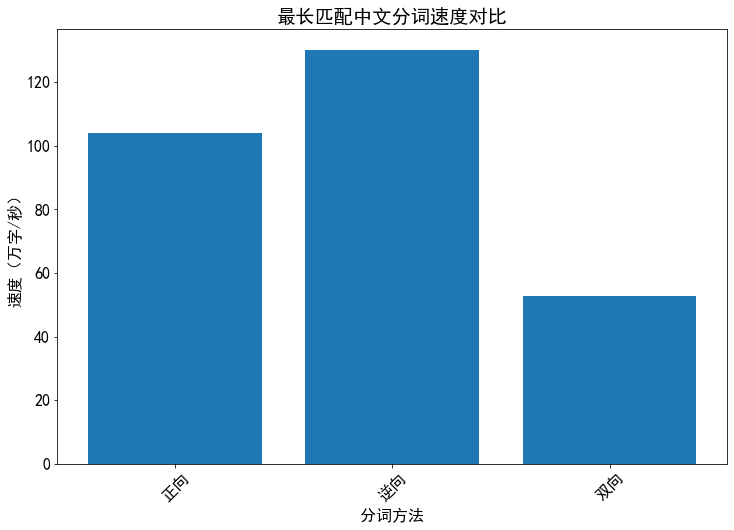

In [29]:
segments,speed = zip(*res)
plt.figure(figsize=(12,8))
plt.bar(segments,speed)
plt.xticks(segments, ("正向","逆向","双向"),rotation=45)
plt.title("最长匹配中文分词速度对比")
plt.xlabel('分词方法')
plt.ylabel('速度（万字/秒）')
#plt.show()
plt.savefig("compare.png", format='png', transparent=True, dpi=300, pad_inches = 0)

### 使用字典树

In [74]:
class Trie:
    def __init__(self):
        self.root = {}  # 用字典构建树结构
        self.end_of_word = '#'  # 用#标志一个单词的结束

    def insert(self, word: str):
        node = self.root
        for char in word:  # 按word的每个字符搜索
            node = node.setdefault(char, {})
            # 如果找到对应字符，进入该字符的分支；如果没有则新建分支，继续生长
        node[self.end_of_word] = self.end_of_word  # 添加结束符

    # 查找一个单词是否完整的在字典树里，所以最后一句判断结束符是否在node中
    def search(self, word: str):
        node = self.root
        for char in word:
            if char not in node:
                return False
            node = node[char]  # 进入分支
        return self.end_of_word in node

    def __contains__(self, word):
        """
        实现魔术方法，可以使用in或not in判断word是否在树中
        """
        return self.search(word)

    # 查找是否有一个单词是这个前缀开始的
    def startsWith(self, prefix: str):
        node = self.root
        for char in prefix:
            if char not in node:
                return False
            node = node[char]
        return True

In [75]:
trie_tree = Trie()
for word in word_dict:
    trie_tree.insert(word)

In [33]:
# 占用内存大小
getsizeof(trie_tree)

56

In [35]:
text = "江西鄱阳湖干枯，中国最大淡水湖变成大草原"
pressure = 10000

evaluate_speed(forward_segment, text, trie_tree)
evaluate_speed(backward_segment, text, trie_tree)
evaluate_speed(bidirectional_segment, text, trie_tree);

30.06 万字/秒
39.63 万字/秒
17.44 万字/秒


**注意：** 使用字典树用于查找一个词是否在词典中进行分词，虽然速度只有用python字典的1/3，但是可以看到保存字典所占的内存空间非常小。

In [38]:
open(msr_gold,encoding="utf-8").readline()
# prf(msr_gold, msr_output, word_dict)

'扬帆  远东  做  与  中国  合作  的  先行  \n'

## 准确率评测

In [3]:
import re

def to_region(segmentation: str) -> list:
    """
    将分词结果转换为区间
    :param segmentation: 商品 和 服务
    :return: [(0, 2), (2, 3), (3, 5)]
    """
    region = []
    start = 0
    for word in re.compile("\\s+").split(segmentation.strip()):
        end = start + len(word)
        region.append((start, end))
        start = end
    return region


def prf(gold: str, pred: str, dic) -> tuple:
    """
    计算P、R、F1
    :param gold: 标准答案文件，比如“商品 和 服务”
    :param pred: 分词结果文件，比如“商品 和服 务”
    :param dic: 词典
    :return: (P, R, F1, OOV_R, IV_R)
    """
    A_size, B_size, A_cap_B_size, OOV, IV, OOV_R, IV_R = 0, 0, 0, 0, 0, 0, 0
    with open(gold,encoding="utf-8") as gd, open(pred,encoding="utf-8") as pd:
        for g, p in zip(gd, pd): # 取出答案：g和预测：p
            A, B = set(to_region(g)), set(to_region(p)) # 得到区间
            A_size += len(A)
            B_size += len(B)
            A_cap_B_size += len(A & B)
            text = re.sub("\\s+", "", g) # 得到原始文本
            for (start, end) in A:
                word = text[start: end]
                if word in dic:
                    IV += 1
                else:
                    OOV += 1

            for (start, end) in A & B:
                word = text[start: end]
                if word in dic:
                    IV_R += 1
                else:
                    OOV_R += 1
    p, r = A_cap_B_size / B_size * 100, A_cap_B_size / A_size * 100
    return p, r, 2 * p * r / (p + r), OOV_R / OOV * 100, IV_R / IV * 100

In [57]:
msr_dict = os.path.join(sighan05, 'gold', 'msr_training_words.utf8')
msr_test = os.path.join(sighan05, 'testing', 'msr_test.utf8') # 没用到？
msr_output = os.path.join(sighan05, 'testing', 'msr_output.txt') # 保存输出结果的空文件
msr_gold = os.path.join(sighan05, 'gold', 'msr_test_gold.utf8') # 正确结果

word_dict = load_dictionary(msr_dict) # 词典文件

### 前向最大匹配

In [50]:
with open(msr_gold,encoding="utf-8") as test, open(msr_output, 'w', encoding="utf-8") as output:
    for line in test:
        output.write("  ".join(forward_segment(re.sub("\\s+", "", line), word_dict)))
        output.write("\n")
print("P:\t%.2f\nR:\t%.2f\nF1:\t%.2f\nOOV-R:\t%.2f\nIV-R:\t%.2f" % prf(msr_gold, msr_output, word_dict))

P:	91.74
R:	95.69
F1:	93.67
OOV-R:	2.47
IV-R:	98.23


### 后向最大匹配

In [51]:
with open(msr_gold,encoding="utf-8") as test, open(msr_output, 'w', encoding="utf-8") as output:
    for line in test:
        output.write("  ".join(backward_segment(re.sub("\\s+", "", line), word_dict)))
        output.write("\n")
print("P:\t%.2f\nR:\t%.2f\nF1:\t%.2f\nOOV-R:\t%.2f\nIV-R:\t%.2f" % prf(msr_gold, msr_output, word_dict))

P:	91.56
R:	95.50
F1:	93.49
OOV-R:	2.47
IV-R:	98.03


### 双向最大匹配

In [52]:
with open(msr_gold,encoding="utf-8") as test, open(msr_output, 'w', encoding="utf-8") as output:
    for line in test:
        output.write("  ".join(bidirectional_segment(re.sub("\\s+", "", line), word_dict)))
        output.write("\n")
print("P:\t%.2f\nR:\t%.2f\nF1:\t%.2f\nOOV-R:\t%.2f\nIV-R:\t%.2f" % prf(msr_gold, msr_output, word_dict))

P:	91.75
R:	95.65
F1:	93.66
OOV-R:	2.47
IV-R:	98.18


## 算法改进
前向最大匹配算法过程：

(1) 令$i=0$，当前指针$p_i$指向输入字串的初始位置，执行下面的操作：

(2) 计算当前指针$p_i$到字串末端的字数（即未被切分字串的长度）$n$， 如果$n=1$，
   转(4) ，结束算法。否则，令$m=$词典中最长单词的字数，如果$m>n$, 令$m=n$
   
(3) 从当前$p_i$起取$m$个汉字作为词$w_i$， 判断：

 - (a) 如果$w_i$确实是词典中的词，则在$w_i$后添加一个切分标志，转(c) ；
 - (b) 如果$w_i$不是词典中的词且$w_i$的长度大于1 ，将$w_i$从右端去掉一个字，转(a)步；否则$w_i$的长度等于1，则在$w_i$后添加一个切分标志，将$w_i$ 作为单字词添加到词典中，执行 (c) 步；
 - (c) 根据$w_i$的长度修改指针$p_i$的位置，如果$p_i$指向字串末端，转(4) ，否则，$i=i+1$，返回 (2) ；

(4) 输出切分结果，结束分词程序。

## 作业

1. 根据上面的算法流程修改前向最大匹配函数。

2. 对比新旧算法的处理速度。  

参考资料：
- [Python Trie树实现最长前缀字符串提取](https://blog.csdn.net/xdshust/article/details/84142893)

### T1

In [5]:
# 原函数
def forward_segment(text, dic, longest):
    word_list = []
    i = 0
    while i < len(text):
        longest_word = text[i]                      # 当前扫描位置的单字
        for j in range(i + 1, len(text) + 1):       # 所有可能的结尾
            word = text[i:j]                        # 从当前位置到结尾的连续字符串
            if word in dic:                         # 在词典中
                if len(word) > len(longest_word):   # 并且更长
                    longest_word = word             # 则更优先输出
        word_list.append(longest_word)              # 输出最长词
        i += len(longest_word)                      # 正向扫描
    return word_list

In [46]:
longest = len(max(word_dict,key=len))
forward_segment(case, word_dict, longest=longest)

['欢迎新', '老师', '生前', '来', '就餐']

In [6]:
def forward_segment_improve(text, dic, longest):
#     longest = len(max(dic,key=len)) # 得到最长单词的字数（不知道如何从前缀树中得到）
#     耗时比下面的循环久多了。。
    word_list = []
    idx = 0
    while idx < len(text):
        n = len(text) - idx # 得到当前指针pi到字串末端的字数n
        # 实现(2)
        if n == 1: 
            break
        elif n < longest:
            m = n
        else:
            m = longest
        # 实现(3)
        for section in range(m,1,-1): # 区间在缩小
            word = text[idx:idx+section]
            if word in dic:
                longest_word = word
                break
        else: # for结束时section为1，实现(b)
            longest_word = text[idx:idx+1]
            dic.add(longest_word)
        word_list.append(longest_word)
        idx += len(longest_word)
    # 实现(4)
    return word_list 

In [50]:
longest = len(max(word_dict,key=len))
forward_segment_improve(case, word_dict, longest=longest)

['欢迎新', '老师', '生前', '来', '就餐']

### T2

In [7]:
def evaluate_speed_new(segment, text, dic,):
    with open(msr_gold,encoding="utf-8") as gd:
        start_time = time.time()
        alltext = 0 
        for idx,g in tqdm(enumerate(gd)): 
            if idx>=10000: # 取10000条(实际只有3984条)
                break
            text = re.sub("\\s+", "", g)
            segment(text, dic, longest)
            alltext += len(text)
        else:
            elapsed_time = time.time() - start_time
            seg_speed = alltext / elapsed_time / 10000
            print('%s: %.2f 万字/秒' % (seg.__name__, seg_speed))

In [11]:
# 仅使用一条文本进行重复发现速度浮动很大，不能正确表示速度，这里使用
text = "江西鄱阳湖干枯，中国最大淡水湖变成大草原"
segments = [forward_segment,forward_segment_improve]
res = []
for seg in segments:
    res.append((seg.__name__, evaluate_speed_new(seg, text, word_dict)))

NameError: name 'msr_gold' is not defined

- 测试了几次发现浮动不大，应该是比较符合真实情况的测试。
- 这里可以发现改进后的方法确实有一定程度的提高。